# Malaria Prediction Visualization
This is the file to visualize the result from the model output 

In [24]:
# Original Figure
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from config import opt
import torch as t
import torch.nn as nn
import torchvision as tv

%matplotlib inline

data_path = './cell_images/'

transforms = tv.transforms.Compose([tv.transforms.RandomRotation(30),
                                       tv.transforms.RandomResizedCrop(224),
                                       tv.transforms.RandomVerticalFlip(),
                                       tv.transforms.ToTensor(),
                                       tv.transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])
    ])

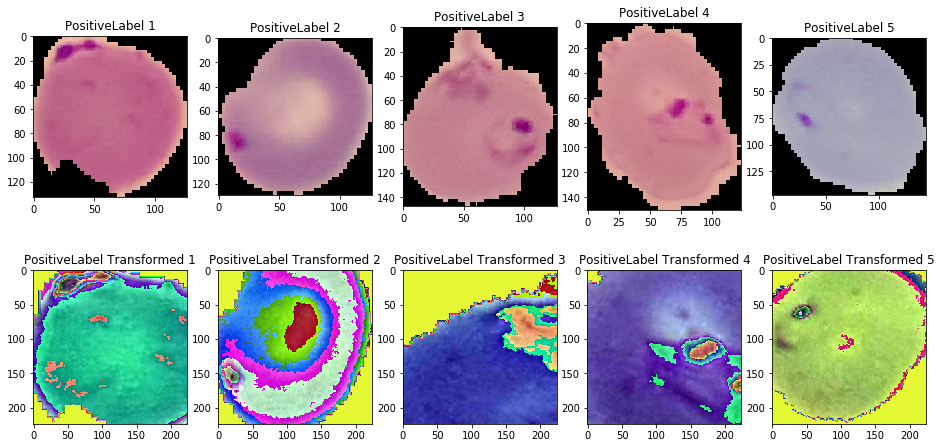

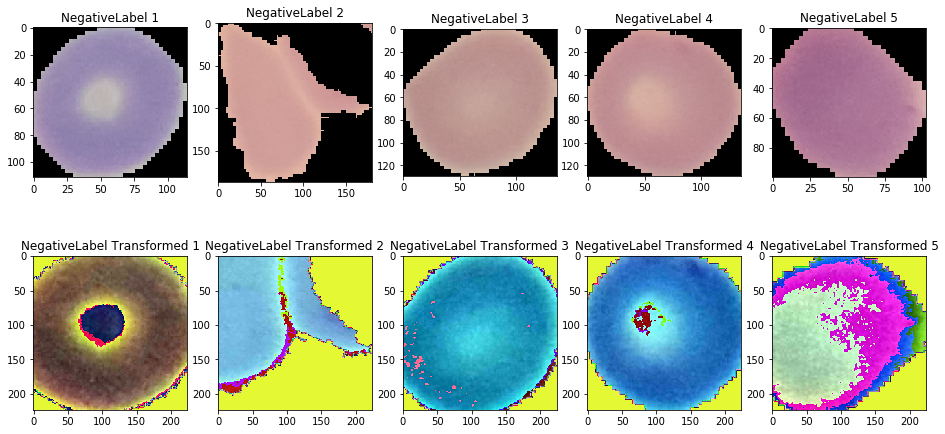

In [16]:
# Original Data
folders = os.listdir(data_path)
pos_path = os.path.join(data_path,folders[0])
neg_path = os.path.join(data_path,folders[1])
samples_per_type = 5

def show(path, samples_per_type, name):
    indices = np.random.randint(0,len(os.listdir(path)),samples_per_type)
    
    fig = plt.figure(figsize=(16,16))
    for i in range(samples_per_type):
        image = Image.open(os.path.join(path,os.listdir(path)[indices[i]]))
        fig.add_subplot(2,5,i+1)
        plt.title(name+'Label '+str(i+1))
        plt.imshow(image)

        image_tran = transforms(image)
        back_transforms = tv.transforms.ToPILImage()
        image_tran = back_transforms(image_tran)
        fig.add_subplot(2,5,i+1+samples_per_type)
        plt.title(name+'Label Transformed '+str(i+1))
        plt.imshow(image_tran)
    
    
    plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)   
    plt.show()

show(pos_path, samples_per_type, 'Positive')
show(neg_path, samples_per_type, 'Negative')


In [26]:
# Prediction
# model
def load_model(path):
    
    model = tv.models.resnet50(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False

    model.fc = nn.Linear(2048, 2, bias=True)

    fc_parameters = model.fc.parameters()

    for param in fc_parameters:
        param.requires_grad = True

    map_location = lambda storage, loc: storage
    if path:
        model.load_state_dict(t.load(path, map_location=map_location))
    
    return model
    

In [78]:
def predict(samples_per_type, path, model, name):
    
    print("Orignal: The image is "+name)
    indices = np.random.randint(0,len(os.listdir(path)),samples_per_type)
    model.eval()
    
    fig = plt.figure(figsize=(10,10))
    for i in range(samples_per_type):
        image = Image.open(os.path.join(path,os.listdir(path)[indices[i]]))
        image_tran = transforms(image)[:3,:,:].unsqueeze(0)
        outputs = model(image_tran)
        idx = torch.argmax(model(image_tran))

        if idx == 0:
            fig.add_subplot(1,3,i+1)
            plt.title("Classfied as Parasitized")
            plt.imshow(image)
        else:
            fig.add_subplot(1,3,i+1)
            plt.title("Classfied as Uninfected")
            plt.imshow(image)
    plt.show()   

Orignal: The image is Parasitized


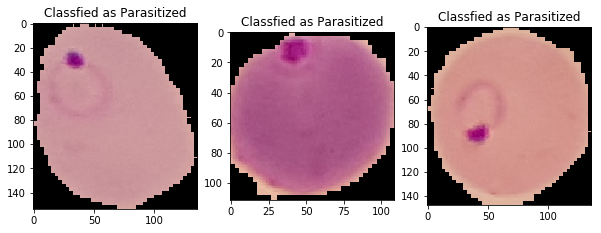

In [79]:
model = load_model(opt.model_path)
predict(3, pos_path, model, "Parasitized")

Orignal: The image is Uninfected


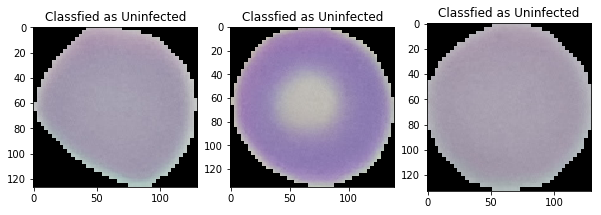

In [80]:
predict(3, neg_path, model, "Uninfected")

# Load the test outputs
outputs.npz is the file that contains the predicted outputs and real labels

In [107]:
data = np.load("outputs.npz")
logits = data['arr_0']
labels = data['arr_1']
len(logits)

2756

In [119]:
from sklearn.metrics import roc_curve, auc
def plot_roc_auc(labels, logits):        
    fpr = dict()
    tpr = dict()
    roc_auc = dict()   
    fpr, tpr, _ = roc_curve(labels, logits)
    roc_auc = auc(fpr, tpr)
   
    plt.figure(figsize=(8,8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.5f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

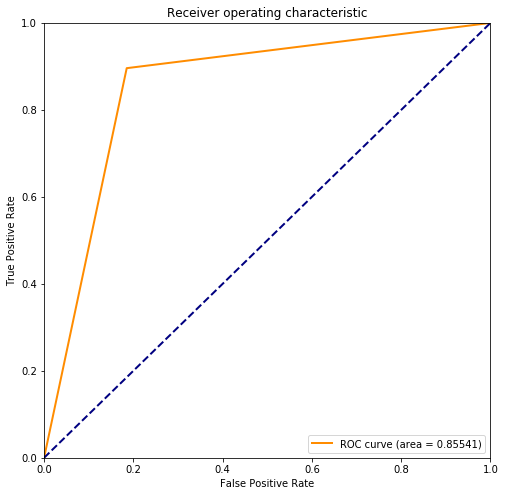

In [120]:
plot_roc_auc(labels, logits)